In [1]:
!python -c "import monai" || pip install -q "monai-weekly[nibabel, tqdm]"
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline

In [2]:
"""
0: background,
1: sacrum,
2: right_hip,
3: left_hip,
4: lumbar_vertebra.        
"""        

'\n0: background,\n1: sacrum,\n2: right_hip,\n3: left_hip,\n4: lumbar_vertebra.        \n'

In [3]:
from monai.utils import first, set_determinism
from monai.transforms import (
    AddChanneld,
    AsDiscrete,
    AsDiscreted,
    EnsureChannelFirstd,
    Compose,
    Resized,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    Activationsd,
    RandCropByPosNegLabeld,
    ScaleIntensityRanged,
    Spacingd,
    ScaleIntensityd,
    SaveImaged,
    EnsureTyped,
    EnsureType,
    Invertd,
)
from monai.handlers.utils import from_engine
from monai.networks.nets import UNet
from monai.networks.layers import Norm
from monai.metrics import DiceMetric
from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai.data import CacheDataset, DataLoader, Dataset, decollate_batch
from monai.config import print_config
from monai.apps import download_and_extract
import torch
import matplotlib.pyplot as plt
import tempfile
import shutil
import os
import glob
from monai.optimizers import Novograd
from monai.utils import get_torch_version_tuple, set_determinism
from ignite.handlers import EarlyStopping, ModelCheckpoint

print_config()


MONAI version: 0.9.dev2209
Numpy version: 1.21.5
Pytorch version: 1.10.2
MONAI flags: HAS_EXT = False, USE_COMPILED = False
MONAI rev id: 9db6e543d6090a3256f20695c1d3224df8cbbc0e
MONAI __file__: C:\Users\Hripsime\anaconda3\envs\abys\lib\site-packages\monai\__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.8
Nibabel version: 3.2.2
scikit-image version: 0.19.1
Pillow version: 8.4.0
Tensorboard version: 2.8.0
gdown version: 4.2.1
TorchVision version: 0.11.3
tqdm version: 4.62.3
lmdb version: 1.3.0
psutil version: 5.9.0
pandas version: 1.4.1
einops version: 0.4.0
transformers version: 4.16.2
mlflow version: 1.23.1

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



## Setup data directory

In [4]:
root_dir  = '../projects/CTPelvic1K_data/'

data_image = os.path.join(root_dir, 'images')
data_mask = os.path.join(root_dir, 'masks')


## Set dataset path

In [5]:
train_images = sorted(glob.glob(os.path.join(data_image, "*data.nii.gz")))
train_labels = sorted(glob.glob(os.path.join(data_mask, "*mask_4label.nii.gz")))

data_dicts = [ {"image": image_name, "mask": label_name} for image_name, label_name in zip(train_images, train_labels) ]
train_files, val_files = data_dicts[:-10], data_dicts[-10:]

In [6]:
set_determinism(seed=0)

In [7]:
train_transforms = Compose(
    [
        LoadImaged(keys=["image", "mask"]),
        EnsureChannelFirstd(keys=["image", "mask"]),
        Orientationd(keys=["image", "mask"], axcodes="RAS"),
        Spacingd(keys=["image", "mask"], pixdim=(1.0, 1.0, 1.0), mode=("bilinear", "nearest")),
        ScaleIntensityRanged(keys=["image"], a_min=-120, a_max=360,b_min=0.0, b_max=1.0, clip=True,),
        CropForegroundd(keys=["image", "mask"], source_key="image"),
        #DataStatsd(keys=["image", "label"], prefix='Data', data_type=True, data_shape=True, value_range=True, data_value=False),
        
        RandCropByPosNegLabeld(
            keys=["image", "mask"],
            label_key="mask",
            spatial_size=(128, 128, 128),
            pos=1,
            neg=1,
            num_samples=4,
            image_key="image",
            image_threshold=0,
        ),
        
        EnsureTyped(keys=["image", "mask"]),
    ]
)
val_transforms = Compose(
    [
        LoadImaged(keys=["image", "mask"]),
        EnsureChannelFirstd(keys=["image", "mask"]),
        Orientationd(keys=["image", "mask"], axcodes="RAS"),
        Spacingd(keys=["image", "mask"], pixdim=(1.0, 1.0, 1.0), mode=("bilinear", "nearest")),
        ScaleIntensityRanged(keys=["image"], a_min=-120, a_max=360,b_min=0.0, b_max=1.0, clip=True,),
        CropForegroundd(keys=["image", "mask"], source_key="image"),
        EnsureTyped(keys=["image", "mask"]),
    ]
)



In [8]:
train_ds = CacheDataset(data=train_files, transform=train_transforms, cache_rate=1.0, num_workers=0)
train_loader = DataLoader(train_ds, batch_size=1, shuffle=True, num_workers=0)

val_ds = CacheDataset(data=val_files, transform=val_transforms, cache_rate=1.0, num_workers=0)
val_loader = DataLoader(val_ds, batch_size=1, num_workers=0)


Loading dataset: 100%|█████████████████████████████████████████████████████████████████| 10/10 [01:28<00:00,  8.87s/it]


In [9]:
import gc #garbage collector
gc.collect()
torch.cuda.empty_cache()
torch.cuda.synchronize()

## Create Model, Loss, Optimizer

In [10]:
# standard PyTorch program style: create UNet, DiceLoss and Adam optimizer

VAL_AMP = True #Automatic mixed precision to accelerate training speed and reduce a memory usage
learning_rate = 2e-4

device=torch.device("cuda:0")     
#device=torch.device("cpu")      
model = UNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=5,
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    num_res_units=2,
    norm=Norm.BATCH,
).to(device)

loss_function = DiceLoss(to_onehot_y=True, softmax=True)
#loss_function = DiceCELoss(to_onehot_y=True, softmax=True, squared_pred=True, batch=True) 

optimizer = torch.optim.Adam(model.parameters(), learning_rate)
#optimizer = Novograd(model.parameters(), learning_rate * 10)
dice_metric = DiceMetric(include_background=False, reduction="mean")


# define inference method
def inference(input):

    def _compute(input):
        return sliding_window_inference(
            inputs=input,
            roi_size=(160, 160, 160),
            sw_batch_size=4,
            predictor=model,
            overlap=0.5,
        )

    if VAL_AMP:
        with torch.cuda.amp.autocast():
            return _compute(input)
    else:
        return _compute(input)
    
# use amp to accelerate training
scaler = torch.cuda.amp.GradScaler()
# enable cuDNN benchmark
torch.backends.cudnn.benchmark = True    

In [11]:
# from pytorchtools import EarlyStopping
# early_stopping = EarlyStopping(patience=20, verbose=True)
# early stopping patience; how long to wait after last time validation loss improved.

## Execute a typical PyTorch training process

In [12]:
max_epochs = 50
val_interval = 1
best_metric = -1
best_metric_epoch = -1

epoch_loss_values = []
metric_values = []
post_pred = Compose([EnsureType(), AsDiscrete(argmax=True, to_onehot=5)])
post_label = Compose([EnsureType(), AsDiscrete(to_onehot=5)])

for epoch in range(max_epochs):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step += 1
        inputs, labels = (
            batch_data["image"].to(device),
            batch_data["mask"].to(device),
        )
        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            outputs = model(inputs)
            loss = loss_function(outputs, labels)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        epoch_loss += loss.item()
        print(
            f"{step}/{len(train_ds) // train_loader.batch_size}, "
            f"train_loss: {loss.item():.4f}")
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            for val_data in val_loader:
                val_inputs, val_labels = (
                    val_data["image"].to(device),
                    val_data["mask"].to(device),
                )
                
                val_outputs = inference(val_inputs)
                val_outputs = [post_pred(i) for i in decollate_batch(val_outputs)]
                val_labels = [post_label(i) for i in decollate_batch(val_labels)]
                
                # compute metric for current iteration
                dice_metric(y_pred=val_outputs, y=val_labels)

            # aggregate the final mean dice result
            metric = dice_metric.aggregate().item()
            
            # reset the status for next validation round
            dice_metric.reset()

            metric_values.append(metric)
            if metric > best_metric:
                best_metric = metric
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), os.path.join(root_dir, "best_metric_model.pth"))
                print("saved new best metric model")
            
            print(
                f"current epoch: {epoch + 1} current mean dice: {metric:.4f}"
                f"\nbest mean dice: {best_metric:.4f} "
                f"at epoch: {best_metric_epoch}"
            )

----------
epoch 1/50
1/31, train_loss: 0.8967
2/31, train_loss: 0.9025
3/31, train_loss: 0.9014
4/31, train_loss: 0.8763
5/31, train_loss: 0.9038
6/31, train_loss: 0.8954
7/31, train_loss: 0.9005
8/31, train_loss: 0.8857
9/31, train_loss: 0.8774
10/31, train_loss: 0.8994
11/31, train_loss: 0.8798
12/31, train_loss: 0.8746
13/31, train_loss: 0.8783
14/31, train_loss: 0.8792
15/31, train_loss: 0.8864
16/31, train_loss: 0.8815
17/31, train_loss: 0.8751
18/31, train_loss: 0.8487
19/31, train_loss: 0.8825
20/31, train_loss: 0.8600
21/31, train_loss: 0.8790
22/31, train_loss: 0.8554
23/31, train_loss: 0.8466
24/31, train_loss: 0.8553
25/31, train_loss: 0.8457
26/31, train_loss: 0.8751
27/31, train_loss: 0.8491
28/31, train_loss: 0.8485
29/31, train_loss: 0.8691
30/31, train_loss: 0.8452
31/31, train_loss: 0.8397
epoch 1 average loss: 0.8740
saved new best metric model
current epoch: 1 current mean dice: 0.1387
best mean dice: 0.1387 at epoch: 1
----------
epoch 2/50
1/31, train_loss: 0.8291

25/31, train_loss: 0.6066
26/31, train_loss: 0.6160
27/31, train_loss: 0.6902
28/31, train_loss: 0.5765
29/31, train_loss: 0.5309
30/31, train_loss: 0.5788
31/31, train_loss: 0.6652
epoch 9 average loss: 0.5908
saved new best metric model
current epoch: 9 current mean dice: 0.6107
best mean dice: 0.6107 at epoch: 9
----------
epoch 10/50
1/31, train_loss: 0.5709
2/31, train_loss: 0.5248
3/31, train_loss: 0.5292
4/31, train_loss: 0.5296
5/31, train_loss: 0.6302
6/31, train_loss: 0.6551
7/31, train_loss: 0.4634
8/31, train_loss: 0.5029
9/31, train_loss: 0.5130
10/31, train_loss: 0.5781
11/31, train_loss: 0.5384
12/31, train_loss: 0.4657
13/31, train_loss: 0.6981
14/31, train_loss: 0.5362
15/31, train_loss: 0.5640
16/31, train_loss: 0.4977
17/31, train_loss: 0.5131
18/31, train_loss: 0.4930
19/31, train_loss: 0.5249
20/31, train_loss: 0.4875
21/31, train_loss: 0.6691
22/31, train_loss: 0.5683
23/31, train_loss: 0.4585
24/31, train_loss: 0.4373
25/31, train_loss: 0.5060
26/31, train_loss: 

12/31, train_loss: 0.5542
13/31, train_loss: 0.3735
14/31, train_loss: 0.5263
15/31, train_loss: 0.3800
16/31, train_loss: 0.3881
17/31, train_loss: 0.3987
18/31, train_loss: 0.5160
19/31, train_loss: 0.4340
20/31, train_loss: 0.4949
21/31, train_loss: 0.4820
22/31, train_loss: 0.3000
23/31, train_loss: 0.2735
24/31, train_loss: 0.4167
25/31, train_loss: 0.4317
26/31, train_loss: 0.3854
27/31, train_loss: 0.3117
28/31, train_loss: 0.4977
29/31, train_loss: 0.4865
30/31, train_loss: 0.3098
31/31, train_loss: 0.3257
epoch 18 average loss: 0.4252
current epoch: 18 current mean dice: 0.5957
best mean dice: 0.8129 at epoch: 17
----------
epoch 19/50
1/31, train_loss: 0.3746
2/31, train_loss: 0.3370
3/31, train_loss: 0.4977
4/31, train_loss: 0.3151
5/31, train_loss: 0.5102
6/31, train_loss: 0.5805
7/31, train_loss: 0.5354
8/31, train_loss: 0.4765
9/31, train_loss: 0.4788
10/31, train_loss: 0.3266
11/31, train_loss: 0.6074
12/31, train_loss: 0.3938
13/31, train_loss: 0.4366
14/31, train_loss:

4/31, train_loss: 0.5592
5/31, train_loss: 0.4690
6/31, train_loss: 0.3585
7/31, train_loss: 0.5054
8/31, train_loss: 0.5477
9/31, train_loss: 0.3293
10/31, train_loss: 0.4044
11/31, train_loss: 0.3661
12/31, train_loss: 0.3957
13/31, train_loss: 0.4339
14/31, train_loss: 0.4966
15/31, train_loss: 0.4113
16/31, train_loss: 0.4279
17/31, train_loss: 0.2980
18/31, train_loss: 0.4010
19/31, train_loss: 0.1963
20/31, train_loss: 0.4816
21/31, train_loss: 0.4932
22/31, train_loss: 0.3195
23/31, train_loss: 0.5151
24/31, train_loss: 0.4734
25/31, train_loss: 0.4593
26/31, train_loss: 0.2824
27/31, train_loss: 0.2920
28/31, train_loss: 0.5158
29/31, train_loss: 0.3372
30/31, train_loss: 0.4593
31/31, train_loss: 0.4110
epoch 27 average loss: 0.4170
saved new best metric model
current epoch: 27 current mean dice: 0.8760
best mean dice: 0.8760 at epoch: 27
----------
epoch 28/50
1/31, train_loss: 0.5173
2/31, train_loss: 0.3114
3/31, train_loss: 0.3489
4/31, train_loss: 0.4672
5/31, train_loss:

29/31, train_loss: 0.2835
30/31, train_loss: 0.3970
31/31, train_loss: 0.3433
epoch 35 average loss: 0.3693
current epoch: 35 current mean dice: 0.8534
best mean dice: 0.8953 at epoch: 31
----------
epoch 36/50
1/31, train_loss: 0.3646
2/31, train_loss: 0.2408
3/31, train_loss: 0.5850
4/31, train_loss: 0.3557
5/31, train_loss: 0.3198
6/31, train_loss: 0.3311
7/31, train_loss: 0.3487
8/31, train_loss: 0.4087
9/31, train_loss: 0.3156
10/31, train_loss: 0.3243
11/31, train_loss: 0.3760
12/31, train_loss: 0.4460
13/31, train_loss: 0.2888
14/31, train_loss: 0.3311
15/31, train_loss: 0.4136
16/31, train_loss: 0.3408
17/31, train_loss: 0.2199
18/31, train_loss: 0.2538
19/31, train_loss: 0.5622
20/31, train_loss: 0.3727
21/31, train_loss: 0.4339
22/31, train_loss: 0.3725
23/31, train_loss: 0.4825
24/31, train_loss: 0.5690
25/31, train_loss: 0.1941
26/31, train_loss: 0.4223
27/31, train_loss: 0.3030
28/31, train_loss: 0.3716
29/31, train_loss: 0.3126
30/31, train_loss: 0.5242
31/31, train_loss:

22/31, train_loss: 0.5189
23/31, train_loss: 0.2722
24/31, train_loss: 0.3986
25/31, train_loss: 0.5152
26/31, train_loss: 0.2453
27/31, train_loss: 0.5014
28/31, train_loss: 0.1403
29/31, train_loss: 0.2061
30/31, train_loss: 0.3326
31/31, train_loss: 0.3781
epoch 44 average loss: 0.3591
saved new best metric model
current epoch: 44 current mean dice: 0.9088
best mean dice: 0.9088 at epoch: 44
----------
epoch 45/50
1/31, train_loss: 0.2448
2/31, train_loss: 0.2064
3/31, train_loss: 0.3739
4/31, train_loss: 0.2875
5/31, train_loss: 0.2018
6/31, train_loss: 0.5610
7/31, train_loss: 0.4519
8/31, train_loss: 0.5048
9/31, train_loss: 0.4958
10/31, train_loss: 0.2612
11/31, train_loss: 0.2946
12/31, train_loss: 0.5278
13/31, train_loss: 0.3501
14/31, train_loss: 0.3798
15/31, train_loss: 0.3527
16/31, train_loss: 0.4399
17/31, train_loss: 0.4566
18/31, train_loss: 0.4194
19/31, train_loss: 0.3990
20/31, train_loss: 0.4425
21/31, train_loss: 0.5661
22/31, train_loss: 0.3446
23/31, train_los

In [13]:
print(
    f"train completed, best_metric: {best_metric:.4f} "
    f"at epoch: {best_metric_epoch}")

train completed, best_metric: 0.9302 at epoch: 50


## Plot the loss and metric

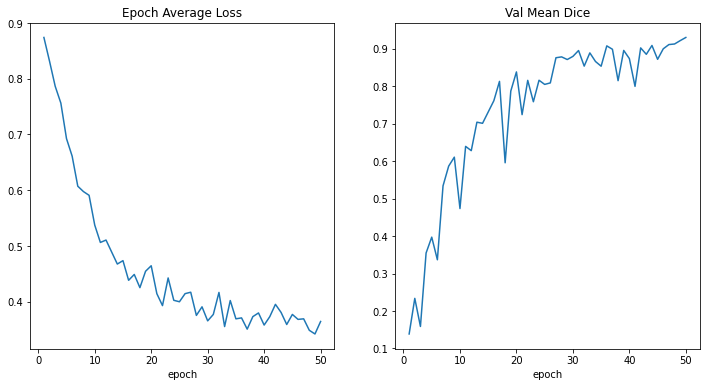

In [14]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y)

plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.show()

## Check best model output with the input image and label

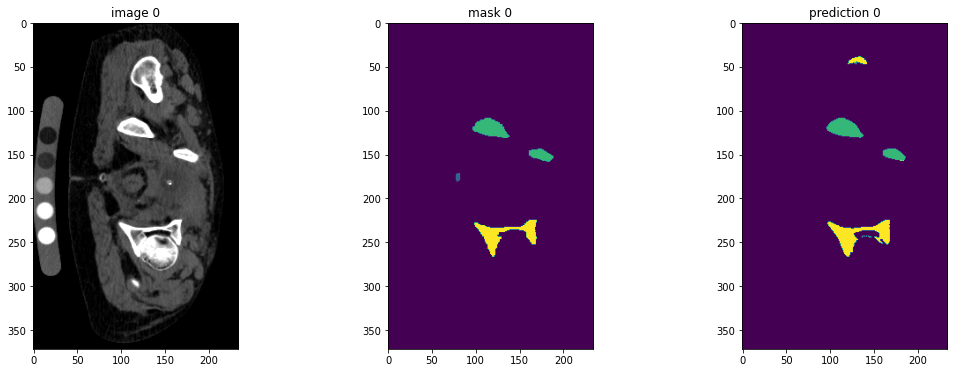

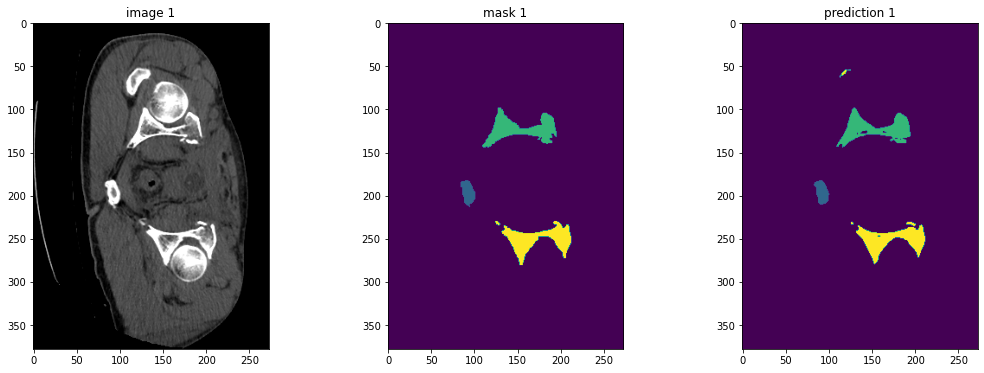

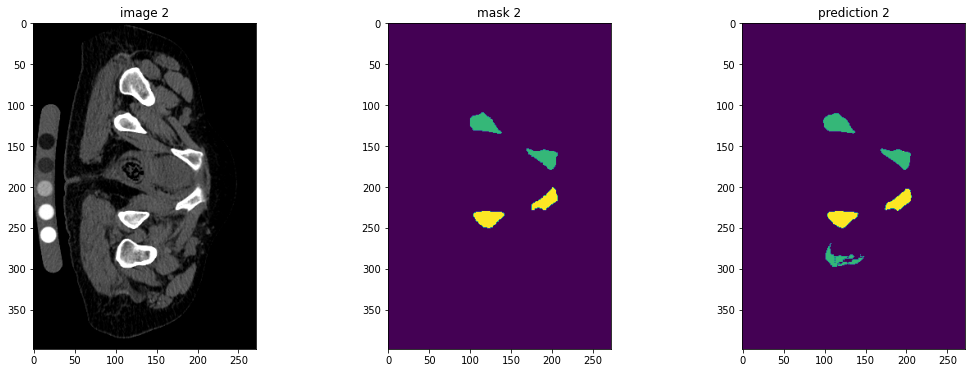

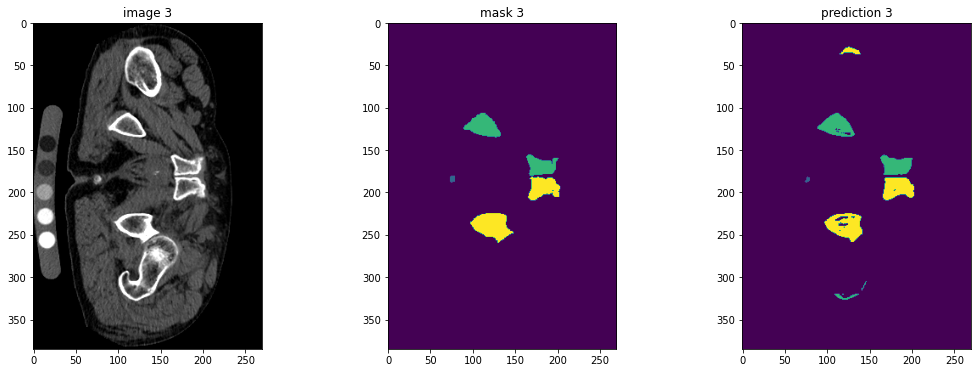

In [15]:
model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))
model.eval()

with torch.no_grad():
    for i, val_data in enumerate(val_loader):
        roi_size = (160, 160, 160)
        sw_batch_size = 4
        val_inputs = val_data["image"].to(device)
        val_outputs = inference(val_inputs)
        
        # plot the slice [:, :, 80]
        plt.figure("check", (18, 6))
        
        plt.subplot(1, 3, 1)
        plt.title(f"image {i}")
        plt.imshow(val_data["image"][0, 0, :, :, 80], cmap="gray")
        
        plt.subplot(1, 3, 2)
        plt.title(f"mask {i}")
        plt.imshow(val_data["mask"][0, 0, :, :, 80])
        
        plt.subplot(1, 3, 3)
        plt.title(f"prediction {i}")
        plt.imshow(torch.argmax(val_outputs, dim=1).detach().cpu()[0, :, :, 80])
        
        plt.show()
        if i == 3:
            break

## Evaluation of Model 

In [16]:
val_org_transforms = Compose(
    [
        LoadImaged(keys=["image", "mask"]),
        EnsureChannelFirstd(keys=["image", "mask"]),
        Orientationd(keys=["image"], axcodes="RAS"),
        Spacingd(keys=["image", "mask"], pixdim=(1.0, 1.0, 1.0), mode=("bilinear", "nearest")),
        ScaleIntensityRanged(keys=["image"], a_min=-120, a_max=360,b_min=0.0, b_max=1.0, clip=True,),
        CropForegroundd(keys=["image"], source_key="image"),
        
        EnsureTyped(keys=["image", "mask"]),
    ]
)

val_org_ds = Dataset(data=val_files, transform=val_org_transforms)
val_org_loader = DataLoader(val_org_ds, batch_size=1, num_workers=0)

post_transforms = Compose([
    EnsureTyped(keys="pred"),
    Invertd(
        keys="pred",
        transform=val_org_transforms,
        orig_keys="image",
        meta_keys="pred_meta_dict",
        orig_meta_keys="image_meta_dict",
        meta_key_postfix="meta_dict",
        nearest_interp=False,
        to_tensor=True,
    ),
    AsDiscreted(keys="pred", argmax=True, to_onehot=5),
    AsDiscreted(keys="mask", to_onehot=5),
])

In [17]:
model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))
model.eval()

with torch.no_grad():
    for val_data in val_org_loader:
        val_inputs = val_data["image"].to(device)
        val_data["pred"] = inference(val_inputs)
        val_data = [post_transforms(i) for i in decollate_batch(val_data)]
        val_outputs, val_labels = from_engine(["pred", "mask"])(val_data)
        # compute metric for current iteration
        dice_metric(y_pred=val_outputs, y=val_labels)

    # aggregate the final mean dice result
    metric_org = dice_metric.aggregate().item()
    # reset the status for next validation round
    dice_metric.reset()

print("Metric on original image spacing: ", metric_org)

ValueError: y_pred and y should have same shapes.